In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('wildfire_data_for_ai_modeling.csv')
df

,fire_year,size_class_encoded,fire_location_latitude,fire_location_longitude,fire_region,fire_start_month,fire_start_weekday,fire_start_part_of_day,fire_type,fuel_type,...,temperature,relative_humidity,wind_speed,fire_spread_rate,bucketing_on_fire,distance_from_water_source,assessment_hectares,bh_hectares,uc_hectares,ex_hectares
0,2021,2,59.522139,-119.926971,High Level,6,0,Morning,Surface,C2,...,28.8,37.0,11.0,3.000000,0,inf,0.01,0.01,10.00,5.50
1,2021,0,52.692262,-116.118960,Rocky,3,2,Morning,Ground,Unknown,...,2.0,50.0,10.0,0.000000,0,inf,0.01,0.01,0.01,0.01
2,2021,0,55.937050,-110.719950,Lac La Biche,4,3,Afternoon,Surface,O1a,...,16.0,19.0,15.0,0.500000,0,inf,0.10,0.10,0.10,0.10
3,2021,0,56.425933,-111.160750,Fort McMurray,4,3,Evening,Surface,O1a,...,7.0,55.0,14.0,0.000000,0,inf,0.01,0.01,0.01,0.01
4,2021,2,53.693450,-116.058633,Edson,11,6,Morning,Surface,O1a,...,12.8,19.0,27.0,5.000000,0,inf,5.00,7.13,7.13,7.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22909,2006,0,51.161883,-114.869317,Calgary,3,6,Evening,Surface,O1a,...,8.0,30.0,20.0,0.000000,0,inf,0.01,0.01,0.01,0.10
22910,2006,0,51.084150,-115.392633,Calgary,3,1,Morning,Surface,Unknown,...,1.0,65.0,0.0,0.000000,0,inf,0.01,0.01,0.01,0.01
22911,2006,1,51.333900,-114.997667,Calgary,3,6,Afternoon,Surface,O1b,...,-1.0,35.0,5.0,0.100000,0,inf,0.70,0.70,0.70,0.70
22912,2006,0,51.071467,-115.316300,Calgary,3,2,Night,Surface,Unknown,...,3.0,70.0,5.0,0.000000,0,inf,0.01,0.01,0.01,0.01


## Feature encoding and normalization

In [ ]:
df = df.drop(columns=[
    'bh_hectares',
    'uc_hectares',
    'ex_hectares',
])

In [ ]:
part_of_day_mapping = {value: index for index, value in  enumerate(df['fire_start_part_of_day'].unique().tolist())}
part_of_day_mapping

{'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}

In [ ]:
df['fire_start_part_of_day'] = df['fire_start_part_of_day'].apply(lambda x: part_of_day_mapping[x])

In [ ]:
df = pd.get_dummies(df, columns=df.select_dtypes(exclude=['int64', 'float64']).columns)

In [ ]:
features_to_normalize = [
    'fire_location_latitude',
    'fire_location_longitude',
    'time_to_discovery',
    'time_to_report',
    'time_to_dispatch',
    'time_to_start_for_fire',
    'time_to_assessment',
    'time_to_ia_arrival',
    'time_to_start_fighting',
    'time_to_first_bucket_drop',
    'total_time_to_extinguish',
    'temperature',
    'relative_humidity',
    'wind_speed',
    'fire_spread_rate',
    'assessment_hectares',
]

for feature in features_to_normalize:
    mean = df[feature].mean()
    std = df[feature].std()
    normalize_fn = lambda x: (x-mean)/std
    df[feature] = df[feature].apply(normalize_fn)

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

df['distance_from_water_source'] = df['distance_from_water_source'].apply(sigmoid)

In [ ]:
df['distance_from_water_source'].mean()

0.9335827850171003

In [ ]:
sigmoid(np.inf)

1.0

In [ ]:
df['distance_from_water_source'].describe()

count    22914.000000
mean         0.933583
std          0.134162
min          0.500000
25%          0.982014
50%          1.000000
75%          1.000000
max          1.000000
Name: distance_from_water_source, dtype: float64

## Models training

In [ ]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define a function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
    title : string
        Title for the chart.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features.
    y : array-like, shape (n_samples)
        Target relative to X for classification or regression; None for unsupervised learning.
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to generate the learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
X = df.copy()
y = X.pop("size_class_encoded")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## XGBoost

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

def evaluate_model_performance_and_plot_learning_curve(model, model_name, X_train, y_train, X_test, y_test, feature_names=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Evaluate model performance through various metrics and plot the learning curve.

    Parameters:
    - model: The trained model object.
    - model_name: Name of the model as a string for labeling plots.
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Testing data and labels.
    - feature_names: Feature names for plotting feature importance. Applicable if the model has feature_importances_ attribute.
    - cv: Cross-validation splitting strategy.
    - n_jobs: Number of jobs to run in parallel for learning_curve computation.
    - train_sizes: Relative or absolute numbers of training examples that will be used to generate the learning curve.
    """
    # Plot Learning Curve
    plt.figure()
    plt.title(f"Learning Curve: {model_name}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

    print('\n\n')

    # Predictions for further metrics
    y_pred = model.predict(X_test)
    # y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0] * len(y_pred)
    y_pred_prob = model.predict_proba(X_test)

    # Accuracy and Log Loss
    print(f"{model_name} Accuracy:", accuracy_score(y_test, y_pred))
    print(f"{model_name} Log Loss:", log_loss(y_test, y_pred_prob))

    print('\n\n')

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1 = report['macro avg']['f1-score']

    # Append Metrics to DataFrame
    global metrics_df
    metrics_df.loc[len(metrics_df)] = [model_name, accuracy, macro_precision, macro_recall, macro_f1]


    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(y_test, y_pred))



In [ ]:
def plot_top_n_feature_importances(model, feature_names, n=10, model_name="Model"):
    """
    Plot the top N feature importances for models that support it.

    Parameters:
    - model: The trained model object with feature_importances_ attribute.
    - feature_names: Feature names corresponding to model feature importances.
    - n: Number of top features to plot.
    - model_name: Name of the model as a string for labeling plots.
    """
    # Check if model has attribute 'feature_importances_'
    if hasattr(model, 'feature_importances_'):
        # Ensure n does not exceed the number of features
        n = min(n, len(feature_names))

        # Get feature importances and their corresponding feature names
        importances = model.feature_importances_
        indices = np.argsort(importances)[-n:]  # Get the indices of top n importances

        # Plot
        plt.figure(figsize=(10, 7))
        plt.title(f'Top {n} Feature Importances in {model_name}')
        plt.barh(range(n), importances[indices], align='center')
        plt.yticks(range(n), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    else:
        print(f"The model does not support feature importances.")


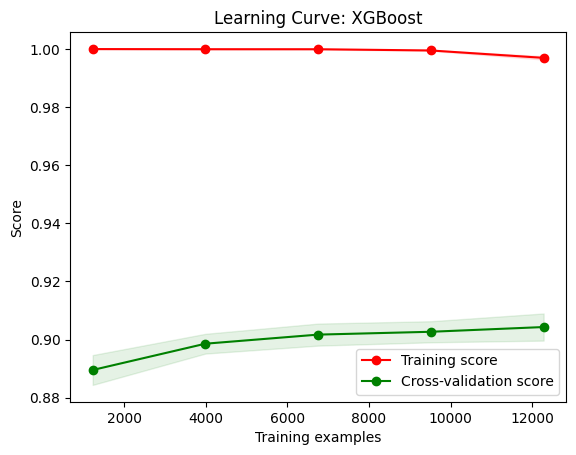




XGBoost Accuracy: 0.90663845543507
XGBoost Log Loss: 0.29681481162522677





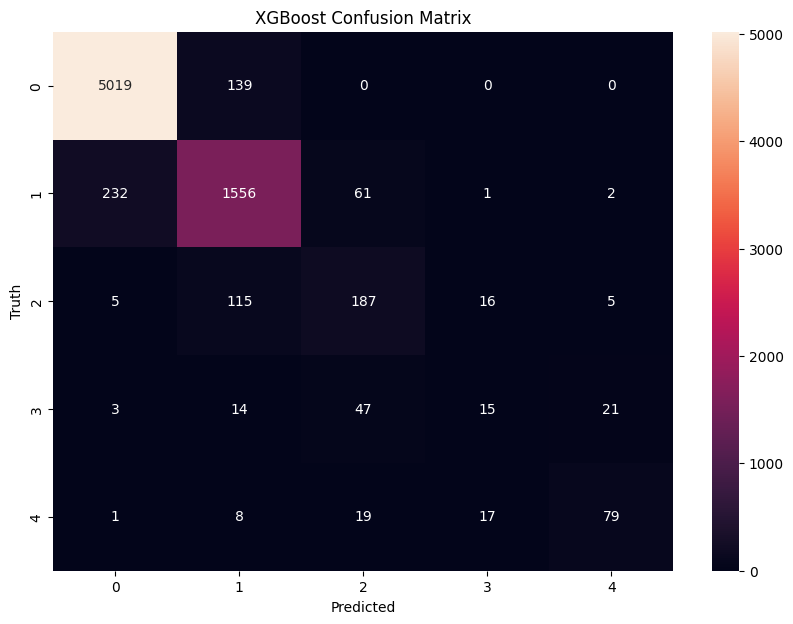

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5158
           1       0.85      0.84      0.84      1852
           2       0.60      0.57      0.58       328
           3       0.31      0.15      0.20       100
           4       0.74      0.64      0.68       124

    accuracy                           0.91      7562
   macro avg       0.69      0.63      0.66      7562
weighted avg       0.90      0.91      0.90      7562



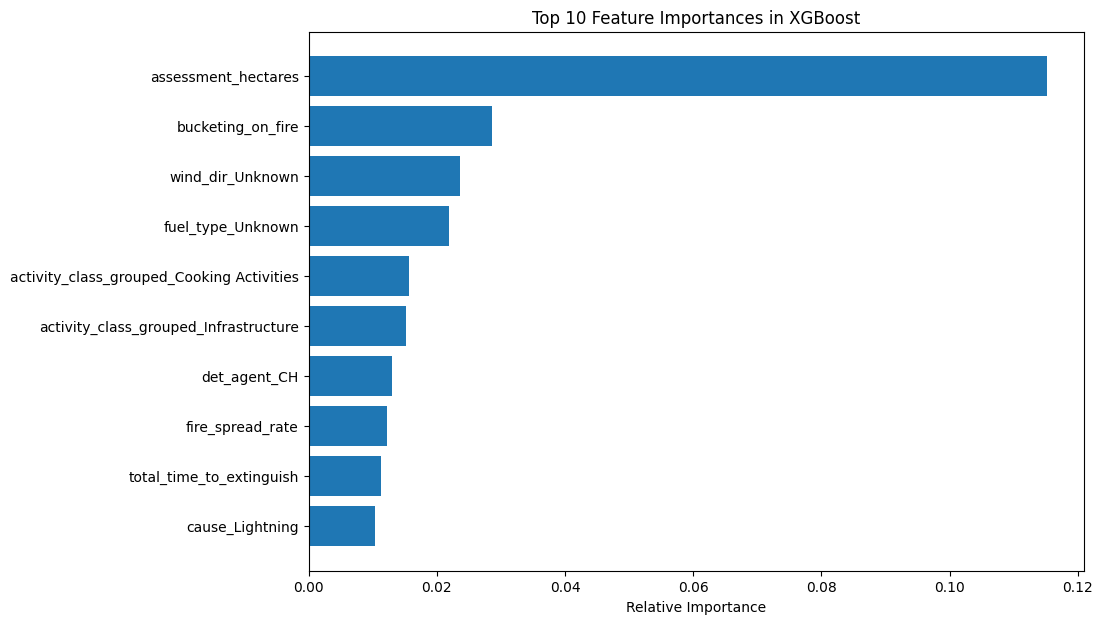

In [ ]:
# Example for XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)

evaluate_model_performance_and_plot_learning_curve(xgb, "XGBoost", X_train, y_train, X_test, y_test, feature_names=X_train.columns)
plot_top_n_feature_importances(xgb, feature_names=X_train.columns, n=10, model_name="XGBoost")



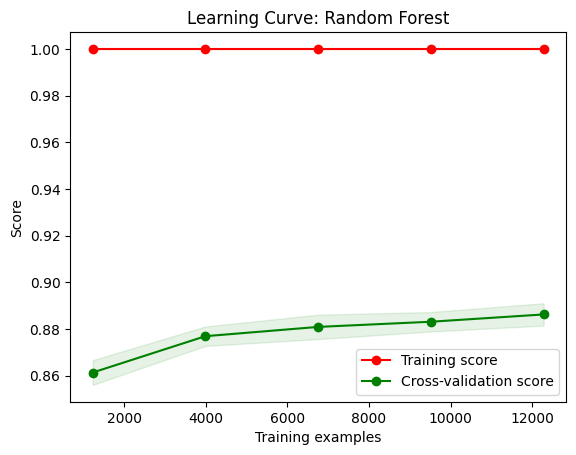




Random Forest Accuracy: 0.8850833112933086
Random Forest Log Loss: 0.3705844212703903





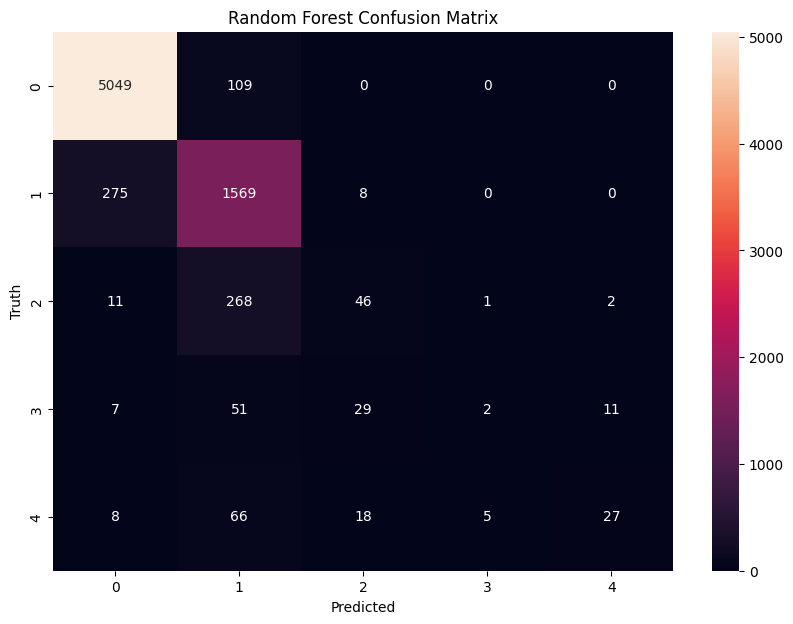

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5158
           1       0.76      0.85      0.80      1852
           2       0.46      0.14      0.21       328
           3       0.25      0.02      0.04       100
           4       0.68      0.22      0.33       124

    accuracy                           0.89      7562
   macro avg       0.62      0.44      0.47      7562
weighted avg       0.86      0.89      0.87      7562



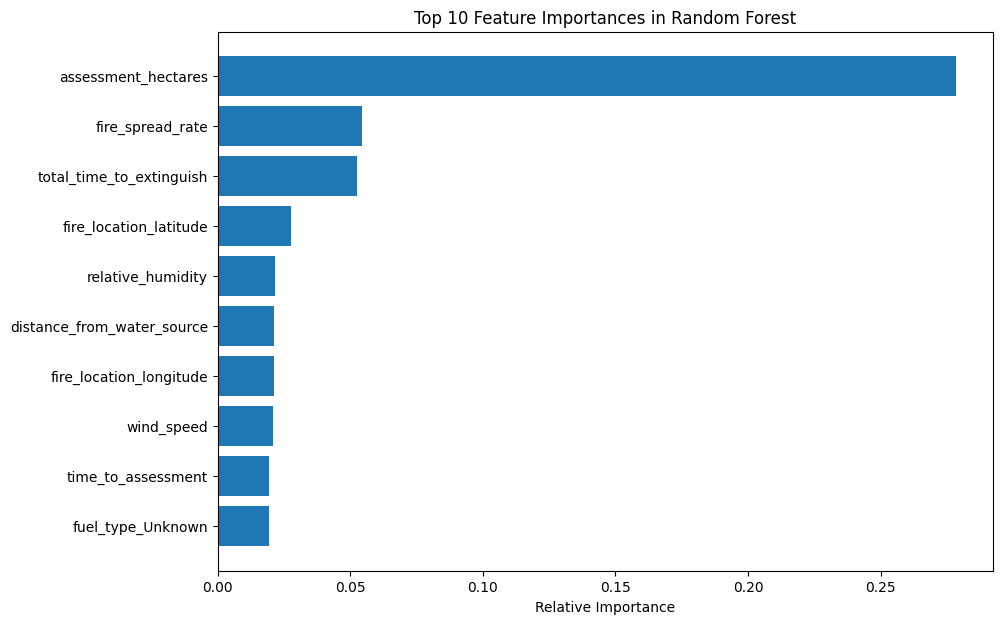

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)

# Fit the model
rf_model.fit(X_train, y_train)

# Evaluate the model's performance
evaluate_model_performance_and_plot_learning_curve(rf_model, "Random Forest", X_train, y_train, X_test, y_test, feature_names=X_train.columns)
plot_top_n_feature_importances(rf_model, feature_names=X_train.columns, n=10, model_name="Random Forest")


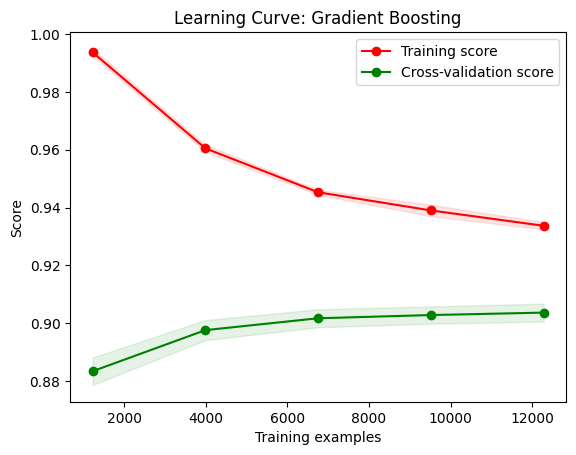




Gradient Boosting Accuracy: 0.907167416027506
Gradient Boosting Log Loss: 0.27950782210044856





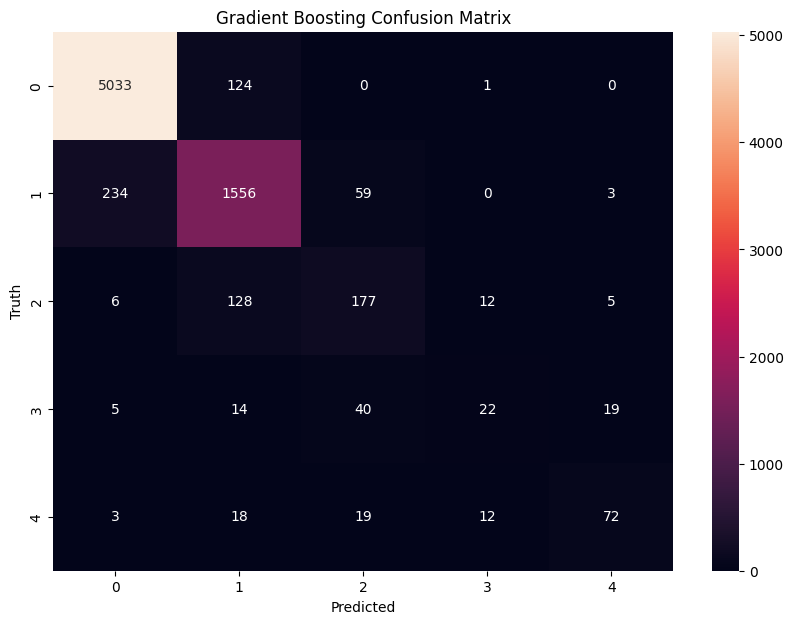

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      5158
           1       0.85      0.84      0.84      1852
           2       0.60      0.54      0.57       328
           3       0.47      0.22      0.30       100
           4       0.73      0.58      0.65       124

    accuracy                           0.91      7562
   macro avg       0.72      0.63      0.66      7562
weighted avg       0.90      0.91      0.90      7562



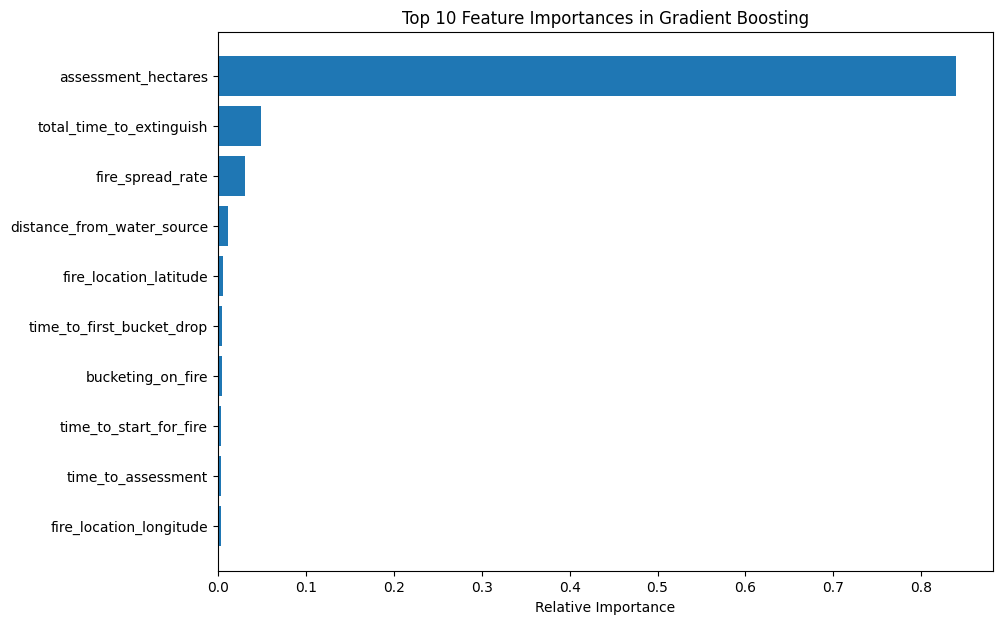

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_name = 'Gradient Boosting'

# Initialize the Gradient Boosting model
gbc_model = GradientBoostingClassifier(n_estimators=100)

# Fit the model
gbc_model.fit(X_train, y_train)

# Evaluate the model's performance
evaluate_model_performance_and_plot_learning_curve(gbc_model, model_name, X_train, y_train, X_test, y_test, feature_names=X_train.columns)
plot_top_n_feature_importances(gbc_model, feature_names=X_train.columns, n=10, model_name=model_name)



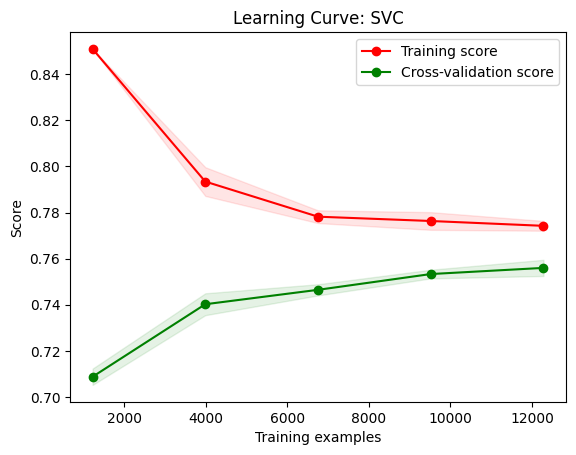




SVC Accuracy: 0.7644802962179318
SVC Log Loss: 0.5628127750998987





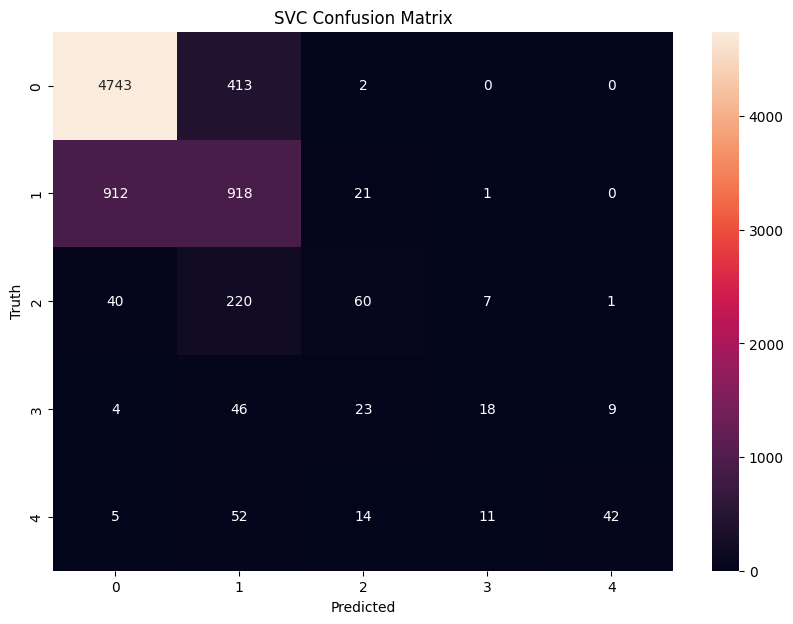

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      5158
           1       0.56      0.50      0.52      1852
           2       0.50      0.18      0.27       328
           3       0.49      0.18      0.26       100
           4       0.81      0.34      0.48       124

    accuracy                           0.76      7562
   macro avg       0.64      0.42      0.48      7562
weighted avg       0.74      0.76      0.75      7562

The model does not support feature importances.


In [ ]:
from sklearn.svm import SVC

model_name = 'SVC'
# Initialize the SVC model
svc_model = SVC(kernel='linear', probability=True)  # Ensure probability=True for SVC

# Fit the model
svc_model.fit(X_train, y_train)

# Evaluate the model's performance
evaluate_model_performance_and_plot_learning_curve(svc_model, "SVC", X_train, y_train, X_test, y_test)
plot_top_n_feature_importances(svc_model, feature_names=X_train.columns, n=10, model_name=model_name)

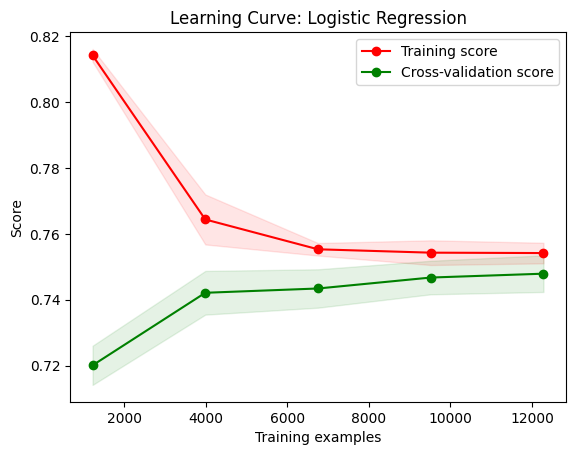




Logistic Regression Accuracy: 0.7560169267389579
Logistic Regression Log Loss: 0.6108023929908798





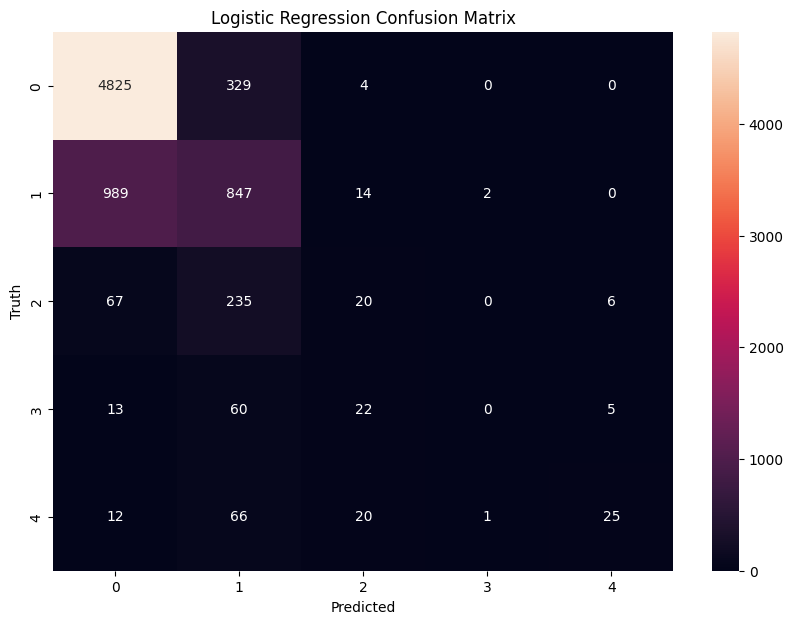

              precision    recall  f1-score   support

           0       0.82      0.94      0.87      5158
           1       0.55      0.46      0.50      1852
           2       0.25      0.06      0.10       328
           3       0.00      0.00      0.00       100
           4       0.69      0.20      0.31       124

    accuracy                           0.76      7562
   macro avg       0.46      0.33      0.36      7562
weighted avg       0.71      0.76      0.73      7562

The model does not support feature importances.


In [ ]:
from sklearn.linear_model import LogisticRegression
model_name = 'Logistic Regression'

# Initialize the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)

# Fit the model
logreg_model.fit(X_train, y_train)

# Evaluate the model's performance
evaluate_model_performance_and_plot_learning_curve(logreg_model, "Logistic Regression", X_train, y_train, X_test, y_test)
plot_top_n_feature_importances(logreg_model, feature_names=X_train.columns, n=10, model_name=model_name)

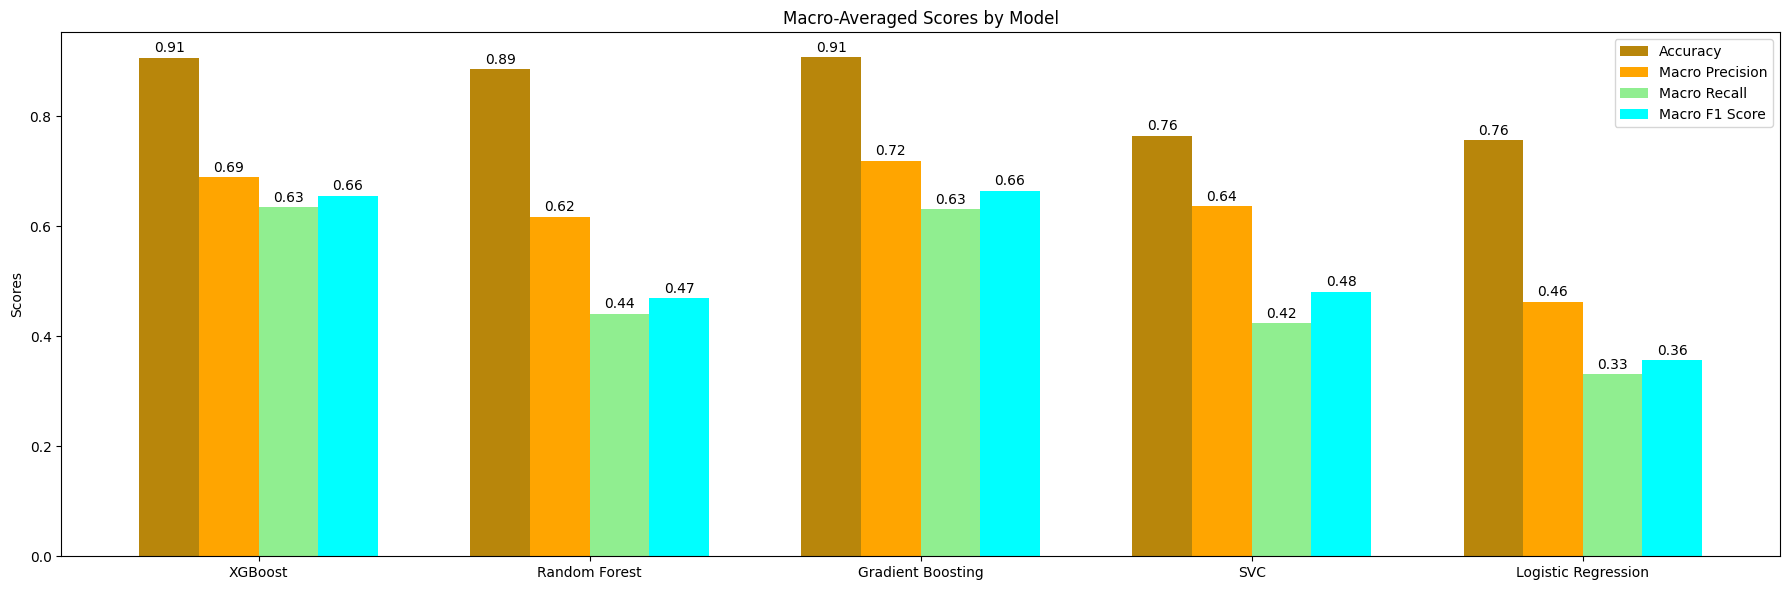

In [ ]:
# Set the size of the plot
plt.figure(figsize=(18, 6))

# Number of models
n_models = len(metrics_df)

# X locations for the groups
ind = np.arange(n_models)

# Width of the bars
width = 0.18

# Plotting
plt.bar(ind, metrics_df['Accuracy'], width, label='Accuracy', color='darkgoldenrod')
plt.bar(ind + width, metrics_df['Precision'], width, label='Macro Precision', color="orange")
plt.bar(ind + 2*width, metrics_df['Recall'], width, label='Macro Recall', color="lightgreen")
plt.bar(ind + 3*width, metrics_df['F1 Score'], width, label='Macro F1 Score', color="cyan")

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Scores')
plt.title('Macro-Averaged Scores by Model')
plt.xticks(ind + width * 1.5, metrics_df['Model'])
plt.legend(loc='best')

# Adding the values on top of the bars
for i in ind:
    plt.text(x=i, y=metrics_df['Accuracy'][i] + 0.01, s=f"{metrics_df['Accuracy'][i]:.2f}", ha='center')
    plt.text(x=i + width, y=metrics_df['Precision'][i] + 0.01, s=f"{metrics_df['Precision'][i]:.2f}", ha='center')
    plt.text(x=i + 2*width, y=metrics_df['Recall'][i] + 0.01, s=f"{metrics_df['Recall'][i]:.2f}", ha='center')
    plt.text(x=i + 3*width, y=metrics_df['F1 Score'][i] + 0.01, s=f"{metrics_df['F1 Score'][i]:.2f}", ha='center')

plt.tight_layout()
plt.show()
